In [2]:
import pandas as pd
import plotly.express as px  # (version 4.7.0 or higher)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, dash_table, dcc, html, Input, Output  # pip install dash (version 2.0.0 or higher)
import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash
import plotly.io as pio
import plotly.express as px

In [4]:
ig_deals_cleaned = pd.read_csv("../Documents/preprocessed.csv")

C:\Users\U6033919\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (17,20,25,31,33,35,37,38,62,68,73,75,76,77,79,81,83,88,89,90,91,92,93,94,96) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [131]:
ig_deals_cleaned['Nic']=pd.to_numeric(ig_deals_cleaned['Nic'], errors='coerce')

In [132]:
month_stats = ig_deals_cleaned.groupby(['month','IssuerBorrowerType']).agg({'Size_m': 'sum'}).reset_index().set_index('month')
#weekly_vols = ig_deals_cleaned.groupby(['week','IssuerBorrowerType']).agg({'Size_m': 'sum'}).reset_index().set_index('week')
weekly_vols =ig_deals_cleaned.groupby('week').agg({'Book_Size': 'sum','Size_m': 'sum', 'tranche_bk_to_cvr':'mean', 'Nic':'mean'}).reset_index()
annual_vols= ig_deals_cleaned.groupby('year').agg({'Size_m': 'sum'})
daily_vols = ig_deals_cleaned.groupby('PricingDate')['Size_m'].sum()

In [26]:
CHART_THEME = "plotly_white"
m_chart = px.bar(x=month_stats.tail(30).index, y=month_stats.tail(30)['Size_m']*1e3, labels=dict(x ="Month", y="Volume $US"), template = "plotly_white")
m_chart

In [30]:
annual_chart =px.bar(x = annual_vols.index, y=annual_vols['Size_m']*1e6, labels=dict(x ="Year", y="Volume $US"), template = "plotly_white")
annual_chart

In [133]:
CHART_THEME = "plotly_white"

# Create figure with secondary y-axis
weekly_fig = make_subplots(specs=[[{"secondary_y": True}]])
weekly_fig.layout.template = CHART_THEME
# Add traces
weekly_fig.add_trace(
    go.Bar(x=weekly_vols.tail(20).index, y=weekly_vols.tail(20)['Size_m']*1e5, name="Volume US$"),
    secondary_y=False,
)
weekly_fig.add_trace(
    go.Scatter(x=weekly_vols.tail(20).index, y=weekly_vols.tail(20)['Nic'], name="New Issue Concession (bp)"),
    secondary_y=True,
)

weekly_fig.layout.height=500
weekly_fig.update_layout(margin = dict(t=50, b=50, l=25, r=25))  # optm the chart space

weekly_fig.update_layout(
    #title='Weekly Volumes and Weekly Average Book To Cover',
    xaxis=dict(tickmode = 'array', tickvals = weekly_vols.index, ticktext = weekly_vols['week']),
    yaxis=dict(
        title='Value:$US',
        titlefont_size=14,
        tickfont_size=12,
        ))

weekly_fig.show()



In [61]:
#YTD Volumes
ytd=ig_deals_cleaned[ig_deals_cleaned['year']==2022].groupby('year')['Size_m'].cumsum().tail(1)
#Last YTD
last_ytd=ig_deals_cleaned[(ig_deals_cleaned['year']==2021) & (ig_deals_cleaned['PricingDate'] <="2021-03-25")].groupby('year')['Size_m'].cumsum().tail(1)
#Full Year 2021
full_last_year=ig_deals_cleaned[(ig_deals_cleaned['PricingDate'] >="2021-01-01") & (ig_deals_cleaned['PricingDate'] <="2021-12-31")].groupby('year')['Size_m'].cumsum().tail(1)

In [84]:
type(float(ytd))

float

In [99]:
ytd

489    441940.8
Name: Size_m, dtype: float64

In [17]:
ig_deals_cleaned[ig_deals_cleaned['year']==2022].groupby('week')['Size_m'].cumsum().tail(1)

489    66400.0
Name: Size_m, dtype: float64

In [86]:
summaries = ig_deals_cleaned

In [88]:
#change date to dtype datetime64[ns]
summaries['PricingDate'] = pd.to_datetime(summaries['PricingDate'])

In [89]:
summaries=summaries.set_index('PricingDate')

In [91]:
#today
summaries.sort_values('PricingDate', ascending=True).resample('d').sum()['Size_m'].tail(1)

PricingDate
2022-03-25    600.0
Freq: D, Name: Size_m, dtype: float64

In [92]:
# weekly
summaries.sort_values('PricingDate', ascending=True).resample('W').sum()['Size_m'].tail(1)

PricingDate
2022-03-27    39300.0
Freq: W-SUN, Name: Size_m, dtype: float64

In [93]:
#this month
summaries.sort_values('PricingDate', ascending=True).resample('M').sum()['Size_m'].tail(1)

PricingDate
2022-03-31    199650.0
Freq: M, Name: Size_m, dtype: float64

In [94]:
#this quarter
summaries.sort_values('PricingDate', ascending=True).resample('Q').sum()['Size_m'].tail(1)

PricingDate
2022-03-31    441940.8
Freq: Q-DEC, Name: Size_m, dtype: float64

In [95]:
#this ytd
summaries.sort_values('PricingDate', ascending=True).resample('A').sum()['Size_m'].tail(1)

PricingDate
2022-12-31    441940.8
Freq: A-DEC, Name: Size_m, dtype: float64

In [98]:
#last ytd
summaries.sort_values('PricingDate', ascending=True).resample('A').sum()['Size_m'].cumsum().get(-2)

9311060.499

In [96]:
#full year last year
summaries.sort_values('PricingDate', ascending=True).resample('A').sum()['Size_m'].get(-2)

1564913.608

In [134]:
#https://plotly.com/python/indicator/

indicators_ptf = go.Figure()
indicators_ptf.layout.template = CHART_THEME
indicators_ptf.add_trace(go.Indicator(
    mode = "number+delta",
    value = (float(ytd))/1000,
    number = {'suffix': " bn"},
    title = {"text": "<br><span style='font-size:0.7em;color:gray'>Today's Count</span>"},
    #delta = {'position': "bottom", 'reference': 0, 'relative': False},
    domain = {'row': 0, 'column': 0}))

indicators_ptf.add_trace(go.Indicator(
    mode = "number+delta",
    value = 1,
    number = {'suffix': " bn"},
    title = {"text": "<br><span style='font-size:0.7em;color:gray'>Today's Issuance</span>"},
    #delta = {'position': "bottom", 'reference': 1, 'relative': False},
    domain = {'row': 1, 'column': 0}))

indicators_ptf.add_trace(go.Indicator(
    mode = "number+delta",
    value = 2,
    number = {'suffix': " bn"},
    title = {"text": "<br><span style='font-size:0.7em;color:gray'>Weekly Issuance</span>"},
    #delta = {'position': "bottom", 'reference': 2, 'relative': False},
    domain = {'row': 2, 'column': 0}))

indicators_ptf.add_trace(go.Indicator(
    mode = "number+delta",
    value = 3,
    number = {'suffix': " bn"},
    title = {"text": "<br><span style='font-size:0.7em;color:gray'>Monthly Issuance</span>"},
    #delta = {'position': "bottom", 'reference': 3, 'relative': False},
    domain = {'row': 3, 'column': 0}))


indicators_ptf.update_layout(
    grid = {'rows': 4, 'columns': 1, 'pattern': "independent"},
    margin=dict(l=50, r=50, t=30, b=30)
)

In [136]:
indicators = go.Figure()
indicators.layout.template = CHART_THEME
indicators.add_trace(go.Indicator(
    mode = "number+delta",
    value = 4,
    number = {'suffix': " bn"},
    title = {"text": "<br><span style='font-size:0.7em;color:gray'>Quarterly Issuance</span>"},
    #delta = {'position': "bottom", 'reference': 0, 'relative': False},
    domain = {'row': 0, 'column': 0}))

indicators.add_trace(go.Indicator(
    mode = "number+delta",
    value = 5,
    number = {'suffix': " bn"},
    title = {"text": "<br><span style='font-size:0.7em;color:gray'>This YTD</span>"},
    #delta = {'position': "bottom", 'reference': 1, 'relative': False},
    domain = {'row': 1, 'column': 0}))

indicators.add_trace(go.Indicator(
    mode = "number+delta",
    value = 6,
    number = {'suffix': " bn"},
    title = {"text": "<br><span style='font-size:0.7em;color:gray'>Last YTD</span>"},
    #delta = {'position': "bottom", 'reference': 2, 'relative': False},
    domain = {'row': 2, 'column': 0}))

indicators.add_trace(go.Indicator(
    mode = "number+delta",
    value = 7,
    number = {'suffix': " bn"},
    title = {"text": "<br><span style='font-size:0.7em;color:gray'>Full Year Last Year</span>"},
    #delta = {'position': "bottom", 'reference': 3, 'relative': False},
    domain = {'row': 3, 'column': 0}))


indicators.update_layout(
    grid = {'rows': 4, 'columns': 1, 'pattern': "independent"},
    margin=dict(l=50, r=50, t=30, b=30)
)

In [137]:
app_second_tab = JupyterDash(__name__, external_stylesheets=[dbc.themes.FLATLY])

app_second_tab.layout = dbc.Container(
    [
        dbc.Row(dbc.Col(html.H2('DEBT TRENDS-OVER DIFFERNET TIME PERIODS', className='text-center text-primary, mb-3'))),  # header row
        
        dbc.Row([  # start of second row
            dbc.Col([  # first column on second row
            html.H5('WEEKLY VOLUMES ($US)', className='text-center'),
            dcc.Graph(id='chrt-portfolio-main',
                      figure=weekly_fig,
                      style={'height':550}),
            html.Hr(),
            ], width={'size': 8, 'offset': 0, 'order': 1}),  # width first column on second row
            dbc.Col([  # second column on second row
            html.H5('MORE STATS', className='text-center'),
            dcc.Graph(id='indicators-ptf',
                      figure=indicators_ptf,
                      style={'height':550}),
            html.Hr()
            ], width={'size': 2, 'offset': 0, 'order': 2}),  # width second column on second row
            dbc.Col([  # third column on second row
            html.H5('OTHER STATS', className='text-center'),
            dcc.Graph(id='indicators-sp',
                      figure=indicators,
                      style={'height':550}),
            html.Hr()
            ], width={'size': 2, 'offset': 0, 'order': 3}),  # width third column on second row
        ]),  # end of second row
        
        dbc.Row([  # start of third row
            dbc.Col([  # first column on third row
                html.H5('DEBT ADDED BY MONTH (US$)', className='text-center'),
                dcc.Graph(id='chrt-portfolio-secondary',
                      figure=m_chart,
                      style={'height':380}),
            ], width={'size': 7, 'offset': 0, 'order': 1}),  # width first column on second row
            dbc.Col([  # second column on third row
                html.H5('ANNUAL VOLUMES (US$)', className='text-center'),
                dcc.Graph(id='pie-top15',
                      figure = annual_chart,
                      style={'height':380}),
            ], width={'size': 5, 'offset': 0, 'order': 2}),  # width second column on second row
        ])  # end of third row
        
    ], fluid=True)

if __name__ == '__main__':
    app_second_tab.run_server(debug=False, port=8051)

 * Running on http://127.0.0.1:8051/ (Press CTRL+C to quit)
127.0.0.1 - - [13/Jul/2022 09:36:38] "GET /_alive_ca641c7e-a4a2-4b02-93fa-3ab8cbfc9161 HTTP/1.1" 200 -


Dash app running on http://127.0.0.1:8051/


127.0.0.1 - - [13/Jul/2022 09:37:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Jul/2022 09:37:01] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [13/Jul/2022 09:37:01] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [13/Jul/2022 09:37:01] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [13/Jul/2022 09:37:01] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -


In [104]:
nic = ig_deals_cleaned['Nic']

In [111]:
nic = pd.to_numeric(nic, errors='coerce')

In [112]:
nic.dtype

dtype('float64')

3.041995200548509

In [114]:
nic_ig = ig_deals_cleaned[['PricingDate','Nic']]

In [117]:
nic_ig['Nic'] = pd.to_numeric(nic_ig['Nic'], errors='coerce')

<ipython-input-117-02025bbbcf1b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='PricingDate'>

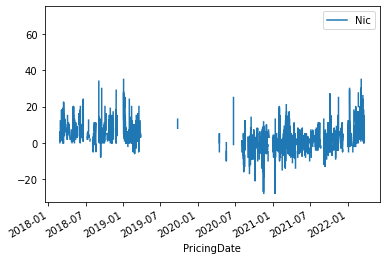

In [119]:
nic_ig.plot(x='PricingDate', kind='line')

In [127]:
#test['PricingDate'] = pd.to_datetime(test['PricingDate'])
nic_ig['PricingDate']=pd.to_datetime(nic_ig['PricingDate'])
nic_ig=nic_ig.set_index('PricingDate')

<ipython-input-127-caca2332b880>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='PricingDate'>

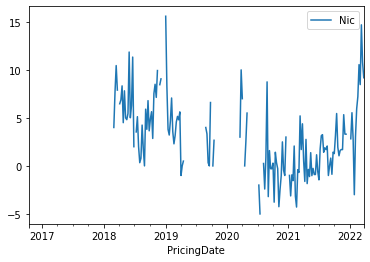

In [129]:
nic_ig.resample('W').mean().plot(kind='line')

In [34]:
test = pd.read_csv('../Documents/test.csv')

In [35]:
#change date to dtype datetime64[ns]
test['PricingDate'] = pd.to_datetime(test['PricingDate'])

In [36]:
test=test.set_index('PricingDate')

In [37]:
#rename columns
test.rename(columns={'Size (m)': 'Size_m', 'Book Size (m)': 'Book_Size'}, inplace=True)

In [38]:
test.sort_values('PricingDate', ascending=True).resample('W').sum()['Size_m'].tail(1)

PricingDate
2022-07-03    22835.0
Freq: W-SUN, Name: Size_m, dtype: float64

In [57]:
#this month
test.resample('M').sum()['Size_m'].tail(1)

PricingDate
2022-06-30    489328.789
Freq: M, Name: Size_m, dtype: float64

In [58]:
#this quarter
test.resample('Q').sum()['Size_m'].tail(1)

PricingDate
2022-06-30    1060218.289
Freq: Q-DEC, Name: Size_m, dtype: float64

In [42]:
#today
test.resample('d').sum()['Size_m'].tail(1)

PricingDate
2022-06-28    8810.0
Freq: D, Name: Size_m, dtype: float64

In [43]:
#Full Year 2021
test.resample('A').sum()['Size_m'].tail(1)

PricingDate
2022-12-31    1060218.289
Freq: A-DEC, Name: Size_m, dtype: float64

In [76]:
#ytd
test.resample('m').sum()['Size_m']

PricingDate
2022-04-30    104985.000
2022-05-31    465904.500
2022-06-30    489328.789
Freq: M, Name: Size_m, dtype: float64

In [81]:
#ytd
test.resample('m').sum()['Size_m'].get(-2)

465904.5

In [53]:
test.groupby(pd.Grouper(freq='m')).cumsum().resample('m').last()

,DealId,Size_m,Tenor,OtherBookrunners,GroupList,OtherGroup,Stabilis,Coupon,Book_Size,NumberOfAccounts,...,AverageLife,TaxCall,PariPassuCall,CrossDefaultCall,AcqCall,Grenium,CollateralAmount,OfferedAmount,Servicer,AssetManager
PricingDate,,,,,,,,,,,,,,,,,,,,,
2022-04-30,2527249375,104985.000,818.50,NaN,NaN,NaN,NaN,1913.2720,151700.0,1078.0,...,NaN,3,0,0,NaN,2.0,NaN,NaN,NaN,NaN
2022-05-31,11460362303,465904.500,3462.80,NaN,NaN,NaN,NaN,11061.5622,855459.0,4201.0,...,NaN,26,14,10,NaN,NaN,NaN,6.0,NaN,NaN
2022-06-30,8958436798,489328.789,2505.96,NaN,NaN,NaN,NaN,10633.1663,488597.2,2496.0,...,NaN,14,8,7,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
test.resample('A').sum()['Size_m'].cumsum().tail(1)

PricingDate
2022-12-31    1060218.289
Freq: A-DEC, Name: Size_m, dtype: float64

In [ ]:
#Last YTD
ig_deals_cleaned[(ig_deals_cleaned['year']=='2021') & (ig_deals_cleaned['PricingDate'] <="2021-03-25")].groupby('year')['Size_m'].cumsum().tail(1)